In [1]:

%matplotlib inline
from hciplot import plot_frames, plot_cubes  # plotting routines
from matplotlib import pyplot as plt
from multiprocessing import cpu_count
import numpy as np
from packaging import version

In [2]:

import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.3"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.3 or above to run this notebook."
    raise ValueError(msg)

VIP version:  1.6.0


In [3]:

from vip_hci.fits import open_fits
from astropy.utils.data import download_file

# alternatively, for local files simply provide their full or relative path. E.g.:
f1 = "C:/Users/bryce/Downloads/METIS_star_hopping/METIS_star_hopping/onaxis_PSF_L_CVC_with_bkg_smedian_z30d_Kmag8.5_v2.fits"
f2 = "C:/Users/bryce/Downloads/METIS_star_hopping/METIS_star_hopping/offaxis_PSF_L_CVC_with_bkg_sQ3_z30d_Kmag8.5_v2.fits"
#f3 = '../datasets/naco_betapic_derot_angles.fits'

cube = open_fits(f1)
psf = open_fits(f2)
angs = np.zeros(shape = 6000)

FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)


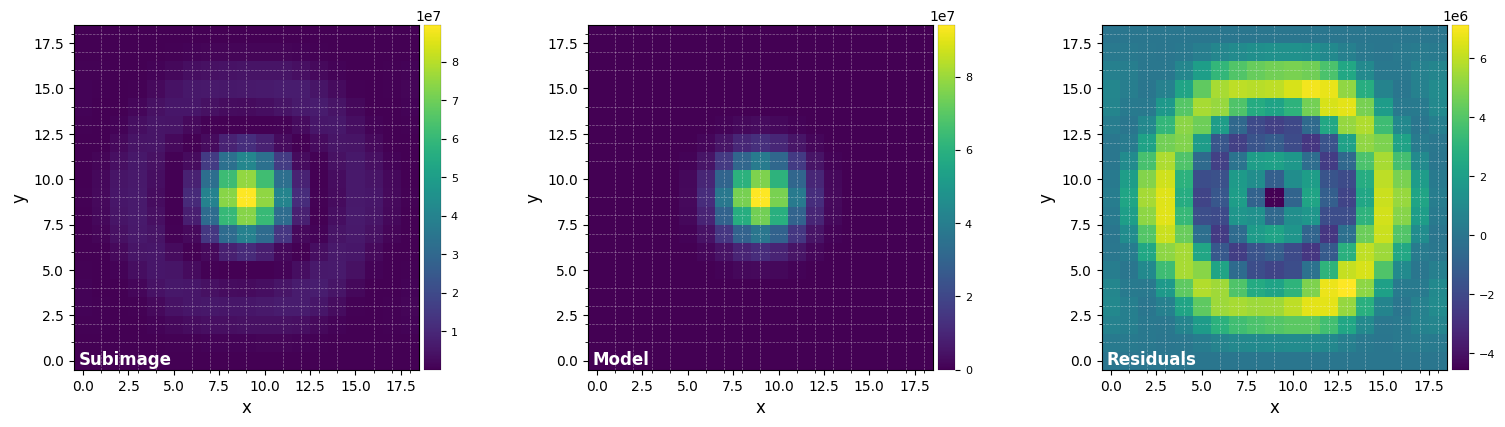

FWHM_y = 3.5005910157512905
FWHM_x = 3.4949576439253818 

centroid y = 9.028970055841148
centroid x = 9.00926627539722
centroid y subim = 9.028970055841148
centroid x subim = 9.00926627539722 

amplitude = 94212111.1613018
theta = 4.954443802703337

Mean FWHM: 3.498
Flux in 1xFWHM aperture: 640483653.378


In [4]:
%matplotlib inline
from vip_hci.fm import normalize_psf
psfn, flux, fwhm_naco = normalize_psf(psf, size=19, debug=True, full_output=True)

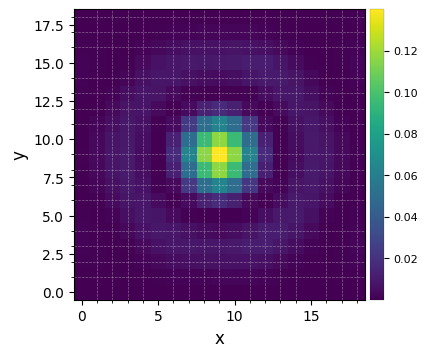

In [5]:
plot_frames(psfn, grid=True, size_factor=4)

In [38]:
from vip_hci.preproc.subsampling import cube_subsample

# make a subsample of 100 images of each of the reference cube files and combine them to one large cube of 2400 images
mags = [7.0,7.5,8.0,8.5]
seeing = ['smedian', 'sQ2', 'sQ3']
versions = ['v1', 'v2']
cube_ref = 1
for mag in mags:
     for see in seeing:
         for ver in versions:
            cube_ref_cur = "C:/Users/bryce/Downloads/METIS_star_hopping/METIS_star_hopping/onaxis_PSF_L_CVC_with_bkg_{}_z30d_Kmag{}_{}.fits".format(see, mag, ver)
            cube_ref_cur = open_fits(cube_ref_cur)
            cube_ref_cur = cube_subsample(cube_ref_cur,60)
            if type(cube_ref) == int:
                cube_ref = cube_ref_cur
            else:
                cube_ref = np.concatenate((cube_ref, cube_ref_cur))
print(cube_ref.shape)

FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (60

In [39]:
from vip_hci.preproc import cube_detect_badfr_correlation
from vip_hci.preproc.subsampling import cube_subsample
good_list = []
# find the mostly correlated images from the 2400 image reference cube, not sure if this is the best way to do this as the numbers dont vastly change, feel like we should either pick subsampling or getting the best correlation
for frame in cube_subsample(cube,60):
    good_idx_p, bad_idx_p = cube_detect_badfr_correlation(cube_ref, frame_ref=frame, 
                                                        crop_size=31, dist='pearson', percentile=95, 
                                                        threshold=None, plot=False, verbose=False)
    good_list += list(good_idx_p)
good_list = list(dict.fromkeys(good_list))
print(len(good_list))

Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
1940


In [8]:
print(len(good_list))
cube_ref_trim = np.zeros(shape = (len(good_list), 293, 293))
for i in range(len(good_list)):
    cube_ref_trim[i] = cube_ref[good_list[i]]

1384


Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-11 17:07:04
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 33.413 GB
System available memory = 12.260 GB
Done vectorizing the frames. Matrix shape: (100, 85849)
Done vectorizing the frames. Matrix shape: (1384, 85849)
Done SVD/PCA with randomized SVD
Running time:  0:00:00.526581
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:33.725866
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


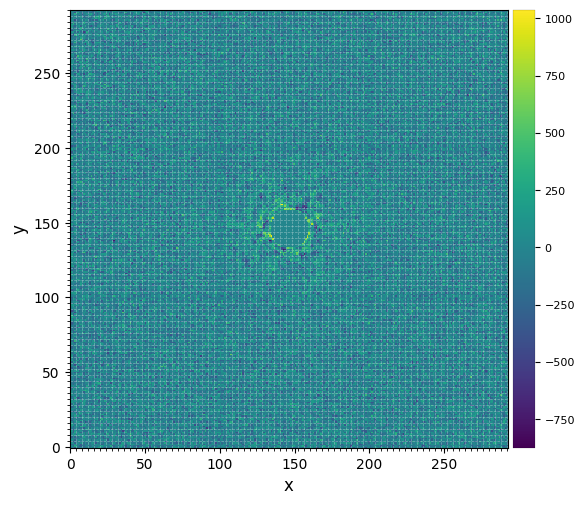

In [23]:
from vip_hci.psfsub import pca
from vip_hci.config.paramenum import SvdMode
SvdMode.CUPY
angs = np.zeros(shape = 100)
cube_sampled = cube_subsample(cube,60)
pca_rdi_fr = pca(cube_sampled, angs, ncomp=42, cube_ref=cube_ref_trim, svd_mode = SvdMode.RANDSVD)
from vip_hci.var import mask_circle
plot_frames(mask_circle(pca_rdi_fr, 13), grid=True)

In [15]:
starphot = float(flux)
print(starphot)

640483653.3776765


ImportError: cannot import name 'ELT_METIS' from 'vip_hci.config' (c:\Users\bryce\anaconda3\envs\vip\Lib\site-packages\vip_hci\config\__init__.py)

In [ ]:
from vip_hci.metrics import contrast_curve
cc_rdi = contrast_curve(cube_subsample(cube,60), angs, psfn, fwhm=fwhm_naco, pxscale=pxscale_naco, starphot=starphot, 
                        sigma=5, nbranch=3, algo=pca, ncomp=10, cube_ref=cube_ref_trim)